# BERT Classification

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import data cleaning libraries
import bs4 as bs
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# import libraries for topic detection
# !pip install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl 
# !pip install torchvision

# !conda create -n data-x python=3.8 anaconda
# !conda activate data-x
# !conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
# !pip install intel-openmp
import torch
torch.cuda.is_available()

False

In [7]:
import matplotlib.pyplot as plt
import os
import random
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator

# Helper Methods

In [8]:
def glass_door_review_cleaner(reviews):
    """
    Cleans a review retrieved from the Glass Door scraper.
    
    Args:
        reviews::[pd.DataFrame]
            The table of given reviews and their statistics.
            
    Return:
       clean_reviews::[pd.DataFrame]
            The cleaned version of the reviews.
    """
    clean_reviews = reviews.drop(["date", "employee_title", "employee_status"], axis = 1)
    
    # remove newline characters
    clean_reviews['pros'] = clean_reviews['pros'].str.replace('\n', '', regex = True)
    clean_reviews['cons'] = clean_reviews['cons'].str.replace('\n', '', regex = True)

    # remove bad strings caught by the web scraper
    badString1 = "Verify your email to continue reading or Resend email"
    badString2 = "Be the first to find this review helpfulHelpfulShareRepor"

    clean_reviews['cons'] = clean_reviews['cons'].str.replace(badString1, '', regex = True)
    clean_reviews['cons'] = clean_reviews['cons'].str.replace(badString2, '', regex = True)

    # compile pros and cons together into a column
    clean_reviews["text"] = "{ Pros. " + clean_reviews['pros'] + " } { Cons. " + clean_reviews['cons'] + " }"

    # remove empty reviews
    clean_reviews = clean_reviews.dropna(subset = ['text'])
    clean_reviews = clean_reviews.reset_index(drop = True)
    
    return clean_reviews

In [9]:
def final_review_cleaner(reviews, lemmatize = True, stem = False):
    '''
    Clean and preprocess a review.

    Args:
        reviews::[pd.DataFrame]
            The table of given reviews and their statistics.
        lemmatize::[boolean]
            A flag for feature lemmatization.
        stem::[boolean]
            A flag for feature stemming.
            
    Return:
        cleaned_reviews::[pd.DataFrame]
            The cleaned version of the reviews.
    '''
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    
    #1. Remove HTML tags
    cleaned_reviews=[]
    for i,review in enumerate(reviews['text']):
    # print progress
        if( (i+1)%500 == 0 ):
            print("Done with %d reviews" %(i+1))
        review = bs.BeautifulSoup(review).text

        #2. Use regex to find emoticons
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)

        #3. Remove punctuation
        review = re.sub("[^a-zA-Z]", " ",review)

        #4. Tokenize into words (all lower case)
        review = review.lower().split()

        #5. Remove stopwords
        eng_stopwords = set(stopwords.words("english"))
            
        clean_review = []
        for word in review:
            if word not in eng_stopwords:
                if lemmatize is True:
                    word = wnl.lemmatize(word)
                elif stem is True:
                    if word == 'oed':
                        continue
                    word = ps.stem(word)
                clean_review.append(word)

        #6. Join the review to one sentence
        review_processed = ' '.join(clean_review + emoticons)
        cleaned_reviews.append(review_processed)
    
    return cleaned_reviews

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def round_two_digit_string(x):
    """
    Rounds a float to two decimal places.
    """
    return str(round(x, 2))

def retrieve_sentiment_analysis(df, column):
    """ Performs a sentiment analysis on the given data.
    
    Args:
        df::[pd.DataFrame]
            The table of given reviews and their statistics.
            
    Return:
        sentiment_df::[pd.DataFrame]
            The reviews with their sentiment analysis data.
    """
    
    analyzer = SentimentIntensityAnalyzer()
    data = {
        "text": [],
        "negative": [],
        "neutral": [],
        "positive": [],
        "compound": []
    }

    for sentence in df[column]:
        vs = analyzer.polarity_scores(sentence)

        data["text"].append(sentence)
        data["negative"].append(round_two_digit_string(vs["neg"]))
        data["neutral"].append(round_two_digit_string(vs["neu"]))
        data["positive"].append(round_two_digit_string(vs["pos"]))
        data["compound"].append(round_two_digit_string(vs["compound"]))
        
    sentiment_df = pd.DataFrame(data)
    
    return sentiment_df

# Training Work for Classifiers

In [11]:
# STEP 1 - OPEN CLASSIFIER DATASET [currently set to classify pros]
train = pd.read_csv("train.csv", header = 0, sep = ",")
train.head()

,Unnamed: 0,ID,Initial_ID,text,S,insurance,safety,balance,retirement,racism,sexism,ageism,benefits,growth,privacy
0,5145,5145,743,Work life balance,NaN,0,0,1,0,0,0,0,0,0,0
1,5134,5134,732,Many opportunities off program to explore diff...,1.0,0,0,0,0,0,0,0,0,1,0
2,5132,5132,730,Flexible Leadership is strong Challenging Lear...,1.0,0,0,1,0,0,0,0,0,1,0
3,5126,5126,724,Collaborative culture,NaN,0,0,0,0,0,0,0,0,0,0
4,5123,5123,721,Culture Work ethics technology quality experts.,1.0,0,0,0,0,0,0,0,0,0,0


In [12]:
# drop useless data
train = train.drop(["Unnamed: 0", "ID", "Initial_ID", "S"], axis = 1)
train.head()

,text,insurance,safety,balance,retirement,racism,sexism,ageism,benefits,growth,privacy
0,Work life balance,0,0,1,0,0,0,0,0,0,0
1,Many opportunities off program to explore diff...,0,0,0,0,0,0,0,0,1,0
2,Flexible Leadership is strong Challenging Lear...,0,0,1,0,0,0,0,0,1,0
3,Collaborative culture,0,0,0,0,0,0,0,0,0,0
4,Culture Work ethics technology quality experts.,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

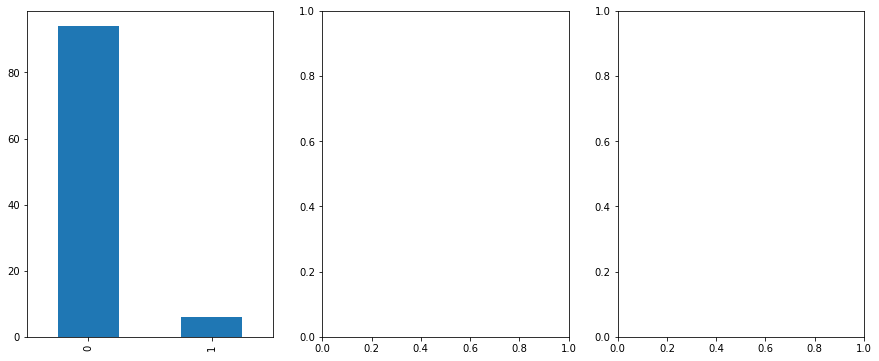

In [13]:
# review the dataset
uvc = train['insurance'].value_counts(sort = True, ascending = False)

fig, ax1 = plt.subplots(1, 3, figsize = (15,6))
uvc.plot(kind = 'bar', ax = ax1[0])

In [14]:
# STEP 2 - TOKENIZE INPUT AND CREATE TRAINING/TESTING SETS
Xtrain_insurance, Xval_insurance = train_test_split(train[['text', 'insurance']], random_state = 0, test_size = 0.2)
Xtrain_safety, Xval_safety = train_test_split(train[['text', 'safety']], random_state = 0, test_size = 0.2) 
Xtrain_balance, Xval_balance = train_test_split(train[['text', 'balance']], random_state = 0, test_size = 0.2)
Xtrain_retirement, Xval_retirement = train_test_split(train[['text', 'retirement']], random_state = 0, test_size = 0.2) 
Xtrain_racism, Xval_racism = train_test_split(train[['text', 'racism']], random_state = 0, test_size = 0.2) 
Xtrain_sexism, Xval_sexism = train_test_split(train[['text', 'sexism']], random_state = 0, test_size = 0.2) 
Xtrain_ageism, Xval_ageism = train_test_split(train[['text', 'ageism']], random_state = 0, test_size = 0.2) 
Xtrain_benefits, Xval_benefits = train_test_split(train[['text', 'benefits']], random_state = 0, test_size = 0.2) 
Xtrain_growth, Xval_growth = train_test_split(train[['text', 'growth']], random_state = 0, test_size = 0.2) 
Xtrain_privacy, Xval_privacy = train_test_split(train[['text', 'privacy']], random_state = 0, test_size = 0.2)

print(Xtrain_insurance.shape, Xval_insurance.shape)

Xtrains = {
    'insurance': Xtrain_insurance,
    'safety': Xtrain_safety,
    'balance': Xtrain_balance,
    'retirement': Xtrain_retirement,
    'racism': Xtrain_racism,
    'sexism': Xtrain_sexism,
    'ageism': Xtrain_ageism,
    'benefits': Xtrain_benefits,
    'growth': Xtrain_growth,
    'privacy': Xtrain_privacy
}

Xvals = {
    'insurance': Xval_insurance,
    'safety': Xval_safety,
    'balance': Xval_balance,
    'retirement': Xval_retirement,
    'racism': Xval_racism,
    'sexism': Xval_sexism,
    'ageism': Xval_ageism,
    'benefits': Xval_benefits,
    'growth': Xval_growth,
    'privacy': Xval_privacy
}

(80, 2) (20, 2)


In [15]:
# For BERT model, the text inputs must be converted to tokens with tokenizer
# Here we use a distiled version of BERT base model (DistilBERT) for fast prototyping
# https://huggingface.co/distilbert-base-cased 
# The tokenizer to use is the pretrained DistilBERT tokenizer
# https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertTokenizer
# Feel free to try on different pretrained BERT model for your own applications but please remember to match the tokenizer with
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# With the selected tokenizer, prepare the inputs and labels with correct datatype for each label
tokenized_train_insurance = tokenizer(Xtrain_insurance['text'].tolist(), padding="max_length", truncation = True)
tokenized_val_insurance = tokenizer(Xval_insurance['text'].tolist(), padding="max_length", truncation = True)
train_labels_insurance = Xtrain_insurance['insurance'].tolist()
val_labels_insurance = Xval_insurance['insurance'].tolist()

tokenized_train_safety = tokenizer(Xtrain_safety['text'].tolist(), padding="max_length", truncation = True)
tokenized_val_safety = tokenizer(Xval_safety['text'].tolist(), padding="max_length", truncation = True)
train_labels_safety = Xtrain_safety['safety'].tolist()
val_labels_safety = Xval_safety['safety'].tolist()

tokenized_train_balance = tokenizer(Xtrain_balance['text'].tolist(), padding="max_length", truncation = True)
tokenized_val_balance = tokenizer(Xval_balance['text'].tolist(), padding="max_length", truncation = True)
train_labels_balance = Xtrain_balance['balance'].tolist()
val_labels_balance = Xval_balance['balance'].tolist()

tokenized_train_retirement = tokenizer(Xtrain_retirement['text'].tolist(), padding="max_length", truncation = True) 
tokenized_val_retirement = tokenizer(Xval_retirement['text'].tolist(), padding="max_length", truncation = True)
train_labels_retirement = Xtrain_retirement['retirement'].tolist()
val_labels_retirement = Xval_retirement['retirement'].tolist()

tokenized_train_racism = tokenizer(Xtrain_racism['text'].tolist(), padding="max_length", truncation = True)
tokenized_val_racism = tokenizer(Xval_racism['text'].tolist(), padding="max_length", truncation = True)
train_labels_racism = Xtrain_racism['racism'].tolist()
val_labels_racism = Xval_racism['racism'].tolist()

tokenized_train_sexism = tokenizer(Xtrain_sexism['text'].tolist(), padding="max_length", truncation = True)
tokenized_val_sexism = tokenizer(Xval_sexism['text'].tolist(), padding="max_length", truncation = True)
train_labels_sexism = Xtrain_sexism['sexism'].tolist()
val_labels_sexism = Xval_sexism['sexism'].tolist()

tokenized_train_ageism = tokenizer(Xtrain_ageism['text'].tolist(), padding="max_length", truncation = True) 
tokenized_val_ageism = tokenizer(Xval_ageism['text'].tolist(), padding="max_length", truncation = True)
train_labels_ageism = Xtrain_ageism['ageism'].tolist()
val_labels_ageism = Xval_ageism['ageism'].tolist()

tokenized_train_benefits = tokenizer(Xtrain_benefits['text'].tolist(), padding="max_length", truncation = True) 
tokenized_val_benefits = tokenizer(Xval_benefits['text'].tolist(), padding="max_length", truncation = True)
train_labels_benefits = Xtrain_benefits['benefits'].tolist()
val_labels_benefits = Xval_benefits['benefits'].tolist()

tokenized_train_growth = tokenizer(Xtrain_growth['text'].tolist(), padding="max_length", truncation = True) 
tokenized_val_growth = tokenizer(Xval_growth['text'].tolist(), padding="max_length", truncation = True)
train_labels_growth=Xtrain_growth['growth'].tolist()
val_labels_growth=Xval_growth['growth'].tolist()

tokenized_train_privacy = tokenizer(Xtrain_privacy['text'].tolist(), padding="max_length", truncation = True) 
tokenized_val_privacy = tokenizer(Xval_privacy['text'].tolist(), padding="max_length", truncation = True)
train_labels_privacy = Xtrain_privacy['privacy'].tolist()
val_labels_privacy = Xval_privacy['privacy'].tolist()

In [16]:
# Create the DataSet with pytorch modules
# https://pytorch.org/docs/stable/data.html
class MYDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset_insurance = MYDataset(tokenized_train_insurance, train_labels_insurance)
val_dataset_insurance = MYDataset(tokenized_val_insurance, val_labels_insurance)
train_loader_insurance = DataLoader(train_dataset_insurance, batch_size = 20, shuffle = False)
val_loader_insurance = DataLoader(val_dataset_insurance, batch_size = 20, shuffle = False)

train_dataset_safety = MYDataset(tokenized_train_safety, train_labels_safety)
val_dataset_safety = MYDataset(tokenized_val_safety, val_labels_safety)
train_loader_safety = DataLoader(train_dataset_safety, batch_size = 20, shuffle = False)
val_loader_safety = DataLoader(val_dataset_safety, batch_size = 20, shuffle = False)

train_dataset_balance = MYDataset(tokenized_train_balance, train_labels_balance)
val_dataset_balance = MYDataset(tokenized_val_balance, val_labels_balance)
train_loader_balance = DataLoader(train_dataset_balance, batch_size = 20, shuffle = False)
val_loader_balance = DataLoader(val_dataset_balance, batch_size = 20, shuffle = False)

train_dataset_retirement = MYDataset(tokenized_train_retirement, train_labels_retirement)
val_dataset_retirement = MYDataset(tokenized_val_retirement, val_labels_retirement)
train_loader_retirement = DataLoader(train_dataset_retirement, batch_size = 20, shuffle = False)
val_loader_retirement = DataLoader(val_dataset_retirement, batch_size = 20, shuffle = False)

train_dataset_racism = MYDataset(tokenized_train_racism, train_labels_racism)
val_dataset_racism = MYDataset(tokenized_val_racism, val_labels_racism)
train_loader_racism = DataLoader(train_dataset_racism, batch_size = 20, shuffle = False)
val_loader_racism = DataLoader(val_dataset_racism, batch_size = 20, shuffle = False)

train_dataset_sexism = MYDataset(tokenized_train_sexism, train_labels_sexism)
val_dataset_sexism = MYDataset(tokenized_val_sexism, val_labels_sexism)
train_loader_sexism = DataLoader(train_dataset_sexism, batch_size = 20, shuffle = False)
val_loader_sexism = DataLoader(val_dataset_sexism, batch_size = 20, shuffle = False)

train_dataset_ageism = MYDataset(tokenized_train_ageism, train_labels_ageism)
val_dataset_ageism = MYDataset(tokenized_val_ageism, val_labels_ageism)
train_loader_ageism = DataLoader(train_dataset_ageism, batch_size = 20, shuffle = False)
val_loader_ageism = DataLoader(val_dataset_ageism, batch_size = 20, shuffle = False)

train_dataset_benefits = MYDataset(tokenized_train_benefits, train_labels_benefits)
val_dataset_benefits = MYDataset(tokenized_val_benefits, val_labels_benefits)
train_loader_benefits = DataLoader(train_dataset_benefits, batch_size = 20, shuffle = False)
val_loader_benefits = DataLoader(val_dataset_benefits, batch_size = 20, shuffle = False)

train_dataset_growth = MYDataset(tokenized_train_growth, train_labels_growth)
val_dataset_growth = MYDataset(tokenized_val_growth, val_labels_growth)
train_loader_growth = DataLoader(train_dataset_growth, batch_size = 20, shuffle = False)
val_loader_growth = DataLoader(val_dataset_growth, batch_size = 20, shuffle = False)

train_dataset_privacy = MYDataset(tokenized_train_privacy, train_labels_privacy)
val_dataset_privacy = MYDataset(tokenized_val_privacy, val_labels_privacy)
train_loader_privacy = DataLoader(train_dataset_privacy, batch_size = 20, shuffle = False)
val_loader_privacy = DataLoader(val_dataset_privacy, batch_size = 20, shuffle = False)

# put all of this into a dictionary to be able to access it all
train_datasets = {
    'insurance': train_dataset_insurance,
    'safety': train_dataset_safety,
    'balance': train_dataset_balance,
    'retirement': train_dataset_retirement,
    'racism': train_dataset_racism,
    'sexism': train_dataset_sexism,
    'ageism': train_dataset_ageism,
    'benefits': train_dataset_benefits,
    'growth': train_dataset_growth,
    'privacy': train_dataset_privacy
}

train_loaders = {
    'insurance': train_loader_insurance,
    'safety': train_loader_safety,
    'balance': train_loader_balance,
    'retirement': train_loader_retirement,
    'racism': train_loader_racism,
    'sexism': train_loader_sexism,
    'ageism': train_loader_ageism,
    'benefits': train_loader_benefits,
    'growth': train_loader_growth,
    'privacy': train_loader_privacy
}

val_datasets = {
    'insurance': val_dataset_insurance,
    'safety': val_dataset_safety,
    'balance': val_dataset_balance,
    'retirement': val_dataset_retirement,
    'racism': val_dataset_racism,
    'sexism': val_dataset_sexism,
    'ageism': val_dataset_ageism,
    'benefits': val_dataset_benefits,
    'growth': val_dataset_growth,
    'privacy': val_dataset_privacy
}

val_loaders = {
    'insurance': val_loader_insurance,
    'safety': val_loader_safety,
    'balance': val_loader_balance,
    'retirement': val_loader_retirement,
    'racism': val_loader_racism,
    'sexism': val_loader_sexism,
    'ageism': val_loader_ageism,
    'benefits': val_loader_benefits,
    'growth': val_loader_growth,
    'privacy': val_loader_privacy
}

In [35]:
# Here we create a function predict_dataset with the model and dataloader as input
# output the true label and predicted label as y_true and y_predict
def predict_dataset(mod, loader, device):
  y_true=[]
  y_predict=[]
  for batch in loader:
    # In batch dictionary, there are a keys for input_ids, attention_mask and labels
    # These three inputs are necessary for DistilBertForSequenceClassification model
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = mod(input_ids, attention_mask=attention_mask, labels=labels)
    # outputs[0] or outputs.loss is the loss and outputs[1] or outputs.logit is the logit
    # use torch.argmax to give the one-hot encoding predictions of logits.
    # https://huggingface.co/transformers/main_classes/output.html
    predictions=torch.argmax(outputs.logits, dim=1)
    # To call the numpy, you must move the gpu tensors to cpu
    y_true_batch=labels.cpu().detach().numpy() 
    y_predict_batch=predictions.cpu().detach().numpy()
    for i in y_true_batch:
      y_true.append(i)
    for j in y_predict_batch:
      y_predict.append(j)
    # Delete the tensors with gradients to save GPU memory
    del input_ids
    del attention_mask
    del labels
    del outputs
    del predictions
  y_true=np.array(y_true)
  y_predict=np.array(y_predict)
  return y_true,y_predict

In [39]:
# create a function that gives classification report and confusion matrix
def classification_evaluate(topic, y_true, y_predict):
  target_names = ['non-' + topic, topic]
  # Use the classification_report module to generate classification report
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
  print(classification_report(y_true, y_predict, target_names = target_names))
  # Use the confusion_matrix module to generate confusion matrix
  # Use ConfusionMatrixDisplay to display confusion matrix with lable classes
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
  cm = confusion_matrix(y_true, y_predict)
  print(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
  disp.plot()

In [40]:
def retrieve_trained_model(topic, train_datasets, val_datasets, val_loaders, train_loaders):
    # STEP 4 - DEFINE PRETRAINED MODEL AND EVALUATE PERFORMANCE
    # activate GPU runtime by calling cuda
    device = torch.device("cpu")        # https://pytorch.org/docs/stable/generated/torch.cuda.device.html?highlight=torch%20device#torch.cuda.device

    # Find the DistilBert model for sequence classification
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") 

    # Assign model to the GPU device
    model.to(device)
    
    # get the true label and predicted label for testing and training set respectively
    y_true_val,y_predict_val = predict_dataset(model, val_loaders[topic], device)     # [is this needed?]
    y_true_train,y_predict_train = predict_dataset(model, train_loaders[topic], device)
    
    # performance evaluation for training set with pre-trained naive model
    classification_evaluate(topic, y_true_train,y_predict_train)
    
    # STEP 4 - TRAIN AND EVALUATE THE MODEL
    # [MAY HAVE TO CHANGE LATER]
    training_args = TrainingArguments(
        output_dir='./results',          # output directory
        num_train_epochs=3,              # total number of training epochs
        per_device_train_batch_size=20,  # batch size per device during training
        per_device_eval_batch_size=40,   # batch size for evaluation
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./logs',            # directory for storing logs
        logging_steps=50,             # Record the logs every 10 steps
        do_eval=True,               # Include in the validation set performance evaluation
        evaluation_strategy="steps"        # Loss are calculated along as training step increases
    )

    trainer = Trainer(
        model = model,                                 # the instantiated 🤗 Transformers model to be trained
        args = training_args,                          # training arguments, defined above
        train_dataset = train_datasets[topic],         # training dataset
        eval_dataset = val_datasets[topic]             # evaluation dataset
    )

    # execute the training
    trainer.train()
    
    return trainer

# Using Classification to Measure Metrics
*Currently set to classify pros*

**Loading the Data**

In [79]:
# open review dataset
prelim_reviews = pd.read_csv("all_reviews.csv", header = 0, sep = ";")
prelim_reviews.head()

,Unnamed: 0,Company,date,employee_title,employee_status,review_title,pros,cons
0,0,ExxonMobil,2021-05-18,IT Analyst,"Current Employee, more than 1 year",Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...
1,1,ExxonMobil,2021-09-04,R&D Manager,Former Employee,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...
2,2,ExxonMobil,2021-10-16,Chemical Technician,"Current Employee, more than 3 years",Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...
3,3,ExxonMobil,2021-10-15,Anonymous,"Current Employee, more than 10 years",I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w..."
4,4,ExxonMobil,2021-10-13,Engineer,Former Employee,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...


In [81]:
# drop weird column
reviews = prelim_reviews.drop(["Unnamed: 0"], axis = 1)

In [82]:
# clean reviews
reviews = glass_door_review_cleaner(reviews)
reviews["text"] = final_review_cleaner(reviews)

# add sentiment analyses
pros_sentiment = retrieve_sentiment_analysis(reviews, "pros")
cons_sentiment = retrieve_sentiment_analysis(reviews, "cons")
combined_sentiment = retrieve_sentiment_analysis(reviews, "text")

reviews["score_pros"] = pros_sentiment["compound"]
reviews["score_cons"] = cons_sentiment["compound"]
reviews["score_combined"] = combined_sentiment["compound"]
reviews.head()

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews


,Company,review_title,pros,cons,text,score_pros,score_cons,score_combined
0,ExxonMobil,Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so far,pro great work environment great benefit prett...,0.95,0.46,0.93
1,ExxonMobil,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...,pro outstanding colleague working high impact ...,0.32,-0.36,-0.05
2,ExxonMobil,Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to join.,pro flexibility nature working like family env...,0.86,0.79,0.92
3,ExxonMobil,I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w...",pro achieving dream partnership company thankf...,0.77,0.28,0.78
4,ExxonMobil,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...,pro competitive pay structured benefit job sat...,0.7,-0.2,0.66


**Classification**

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

               precision    recall  f1-score   support

non-insurance       0.93      1.00      0.96        74
    insurance       0.00      0.00      0.00         6

     accuracy                           0.93        80
    macro avg       0.46      0.50      0.48        80
 weighted avg       0.86      0.93      0.89        80

[[74  0]
 [ 6  0]]


***** Running training *****
  Num examples = 80
  Num Epochs = 3
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




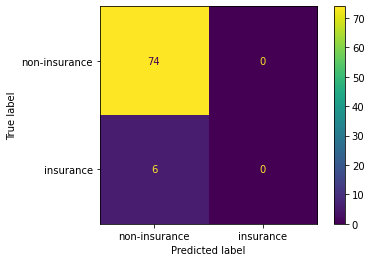

In [41]:
insurance_classifier = retrieve_trained_model("insurance", train_datasets, val_datasets, val_loaders, train_loaders)

In [89]:
reviews["insurance"] = insurance_classifier.predict(reviews["pros"])["predictions"]

***** Running Prediction *****
  Num examples = 9290
  Batch size = 40


TypeError: vars() argument must have __dict__ attribute

In [94]:
Xvals["insurance"]

,text,insurance
26,The team I worked with was very inclusive and ...,0
86,Competitive workplace offering opportunity to ...,0
2,Flexible Leadership is strong Challenging Lear...,0
55,Great benefits,0
75,Smart people,0
93,good leadership culture that encourages risk t...,0
16,Great leadership,0
73,Challenging opportunities and work environment...,0
54,Career progression,0
95,work life balance is great.,0
